# Test orbits in the Nbody example

Begin with the usual imports

In [1]:
import os
import copy
import yaml
import time
import pyEXP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from os.path import exists

plt.rcParams['figure.figsize'] = [12, 9]

/home/weinberg/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Switch to the working directory
I like to be explicit about my working directory but you don't need to do this here.  It would be sufficient to simply pass the full path to the coefficient factory below.   Change the following line to point at the directory where you've computed the Better example.

In [2]:
 os.chdir('../Data')

### Configure the two basis instances

In [3]:
# Create the basis configs
#
disk_config = """
id           : cylinder
parameters   :
  acyl       : 0.01
  hcyl       : 0.001
  lmaxfid    : 32
  mmax       : 6
  nmaxfid    : 32
  nmax       : 12
  ncylodd    : 3
  ncylnx     : 128
  ncylny     : 64
  rnum       : 200
  pnum       : 1
  tnum       : 80
  rcylmin    : 0.001
  rcylmax    : 20
  ashift     : 0
  logr       : false
  density    : true
  eof_file   : eof.cache.run0
"""


# Construct the basis instance
#
disk_basis = pyEXP.basis.Basis.factory(disk_config)

halo_config = """
id           : sphereSL
parameters  :
  numr      : 2000
  rmin      : 0.0001
  rmax      : 1.95
  Lmax      : 6
  nmax      : 20
  rmapping  : 0.0667
  scale     : 1.0
  modelname : SLGridSph.model
  cachename : SLGridSph.cache.run0
"""

halo_basis = pyEXP.basis.Basis.factory(halo_config)

Cylindrical: parameter 'density' is deprecated. The density field will be computed regardless.
Cylinder: parameter 'eof_file' is deprecated. and will be removed in a future release. Please use 'cachename' instead.
---- EmpCylSL::ReadH5Cache: read <eof.cache.run0>
---- EmpCylSL::read_cache: table forwarded to all processes
Cylindrical::orthoTest: worst=0.00529316
---- SLGridSph::ReadH5Cache: successfully read basis cache <SLGridSph.cache.run0>
SphericalSL::orthoTest: worst=0.000610644


### Read the coefficients
This is a HDF5 file previously computed using the `make_coefficients_MPI.py` script.  You simply need to point `coeffile` at some coefficient file.   In this notebook, we will make a copy of the originaly coefficient set 'coefs0' to get a working copy 'coefs' that will be used for MSSA updates.

In [4]:
cfiles = {'star': 'outcoef.star disk.run0', 'dark': 'outcoef.dark halo.run0'}
bases  = {'star': disk_basis, 'dark': halo_basis}
coefs  = {}
for v in cfiles:
    coefs[v] = pyEXP.coefs.Coefs.factory(cfiles[v])

### Try some orbits

These are the first few orbits from the disk.bods file in the Better example.

In [5]:
ps = [
[ -2.453345713293113e-02, -2.176585701352192e-02,  2.190954189595003e-04,  9.898102156942556e-01, -9.407741389799680e-01, -2.093074266306088e-03],
[ -5.097889752210816e-03, -2.637665238545082e-03, -6.737956477848375e-05, -6.315621130916915e-02, -8.504599224510273e-01, -3.784117854422998e-02],
[ 2.174275216854675e-03, -4.331380819563788e-03, -7.096725310036440e-04,  1.241742173685721e+00,  6.534792496349362e-01, -2.970458491433800e-01],
[ 2.974416485792808e-03,  1.244885430395817e-02, -4.782015748023132e-04, -1.164560246686921e+00, -2.440298201612964e-01,  2.315413259022049e-01],
[ -1.413124228197057e-03, -1.690944947852846e-02,  1.245070996974345e-03,  6.367784655950125e-01, -1.679871874453294e-01,  3.273236321411352e-01],
[ -1.280458005487285e-02, -8.542418282997106e-03, -2.339554507704507e-04,  3.114123749474838e-01, -1.115235955322072e+00, -1.021635811177709e-01],
[ 2.649471384314003e-02,  2.101414530216917e-02, -5.176942326470236e-04, -8.692455058024244e-01,  1.163029038914984e+00, -1.420375621267790e-01],
[ -2.374108408394835e-02,  3.263859600272861e-03, -1.028571507921737e-03,  5.161815290024041e-02, -1.242691023470689e+00,  1.408512062020473e-02],
[ -5.509567882651307e-02, -1.106866271313107e-02, -2.785558843976097e-04,  2.843404509325850e-01, -1.374000244061650e+00, -8.867814841024124e-03],
[ 1.159306830688306e-03, -1.746471541137801e-02, -9.487876579279408e-04,  1.106345971597643e+00, -1.490708776808107e-01,  4.826747533399856e-02],
[ 5.629269497537969e-03,  8.733628899677335e-03, -2.959718061888675e-05, -8.286624871567181e-01,  8.637787665967859e-01,  3.959547104072309e-01],
[ -3.277641144255423e-02,  1.852870102405274e-03, -6.407166214496016e-04, -2.257344259800595e-01, -1.332017840202925e+00, -2.732886103917575e-02],
[ -5.594575057792972e-02, -5.323014613276098e-02, -3.377175737333276e-04,  9.731892675027803e-01, -1.028893433282540e+00,  2.252778369967723e-02] ]
       
model = [[bases['star'], coefs['star']], [bases['dark'], coefs['dark']]]

func = pyEXP.basis.AllTimeAccel()

#                      Start time ----------------------+    +----------End time
#                                                                 |      |
#                                                                 v     v
times, orbits = pyEXP.basis.IntegrateOrbits(0.0, 0.2, 0.001, ps, model, func)
#                                                                             ^        ^
#                                                                             |         |
#                       Time step--------------------------------+        +---------IC array

###  Plot the x-y and x-z projections of the disk IC orbits

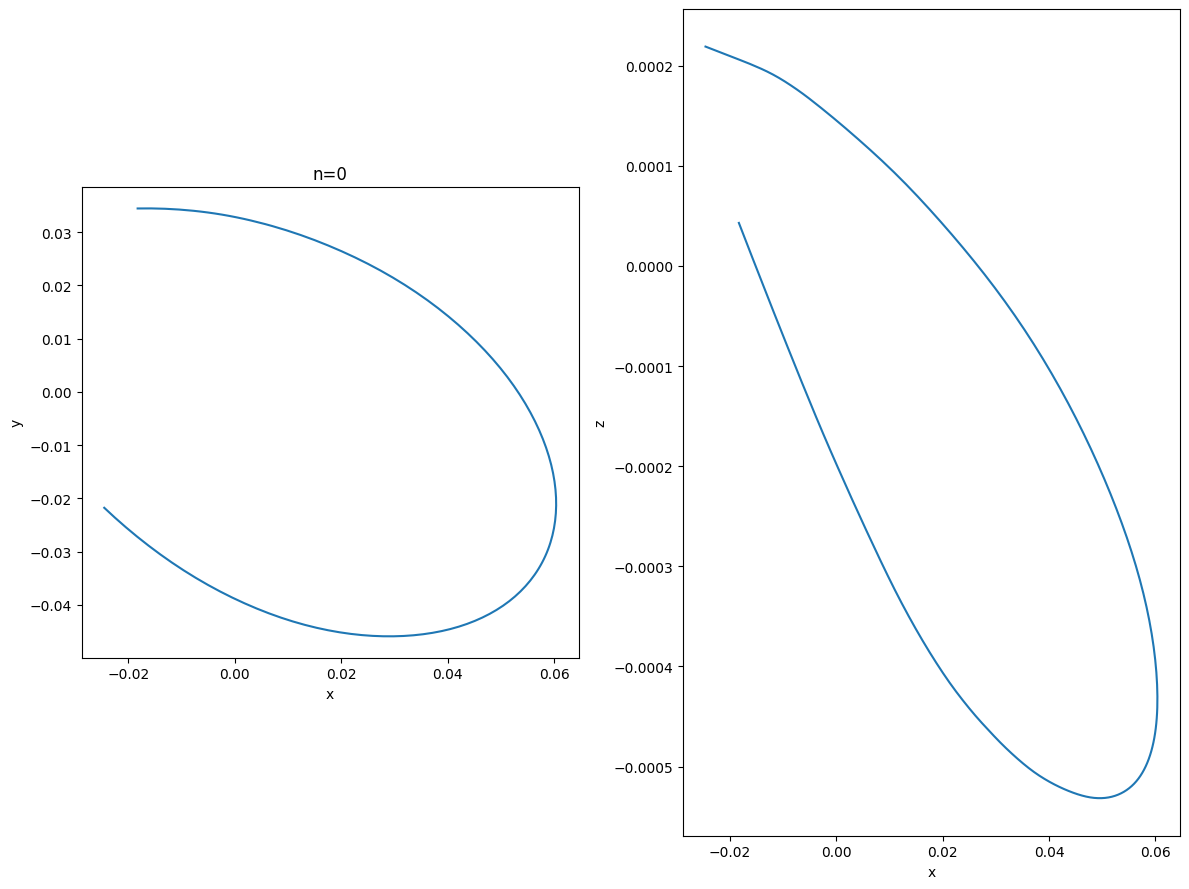

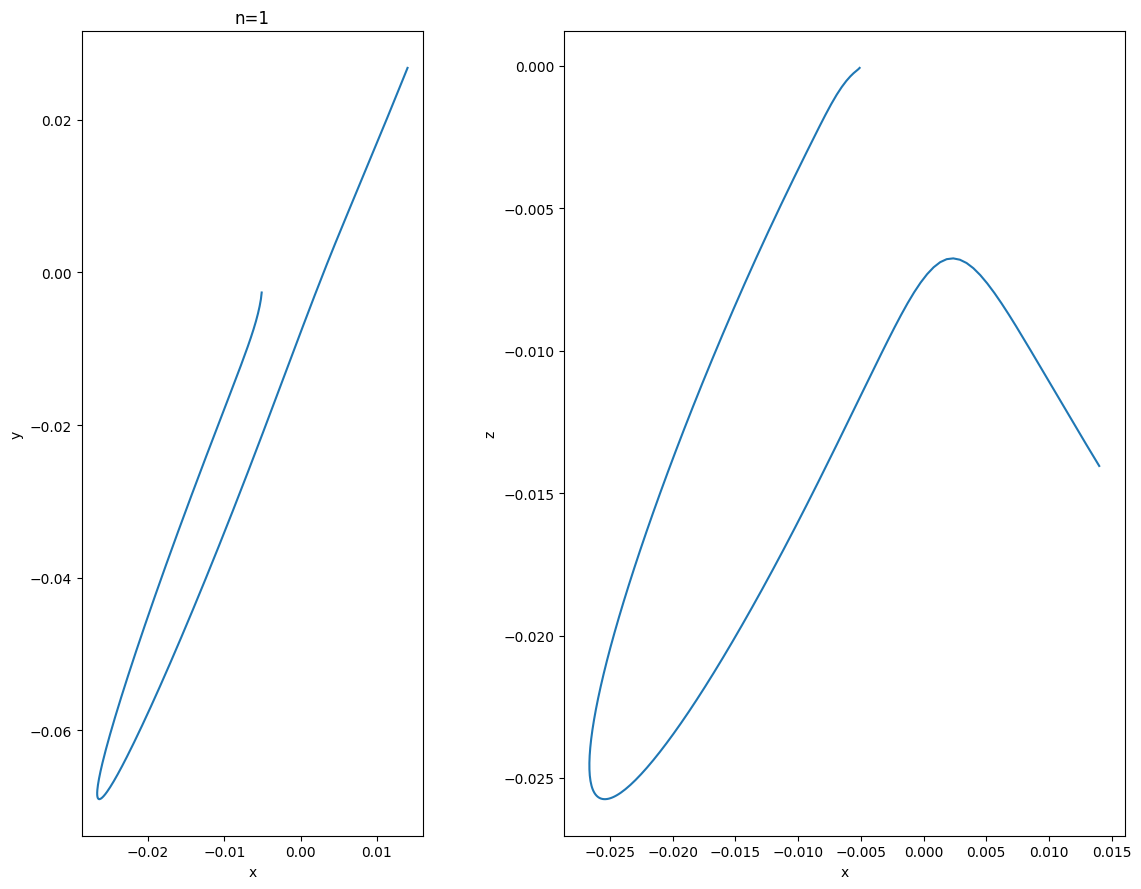

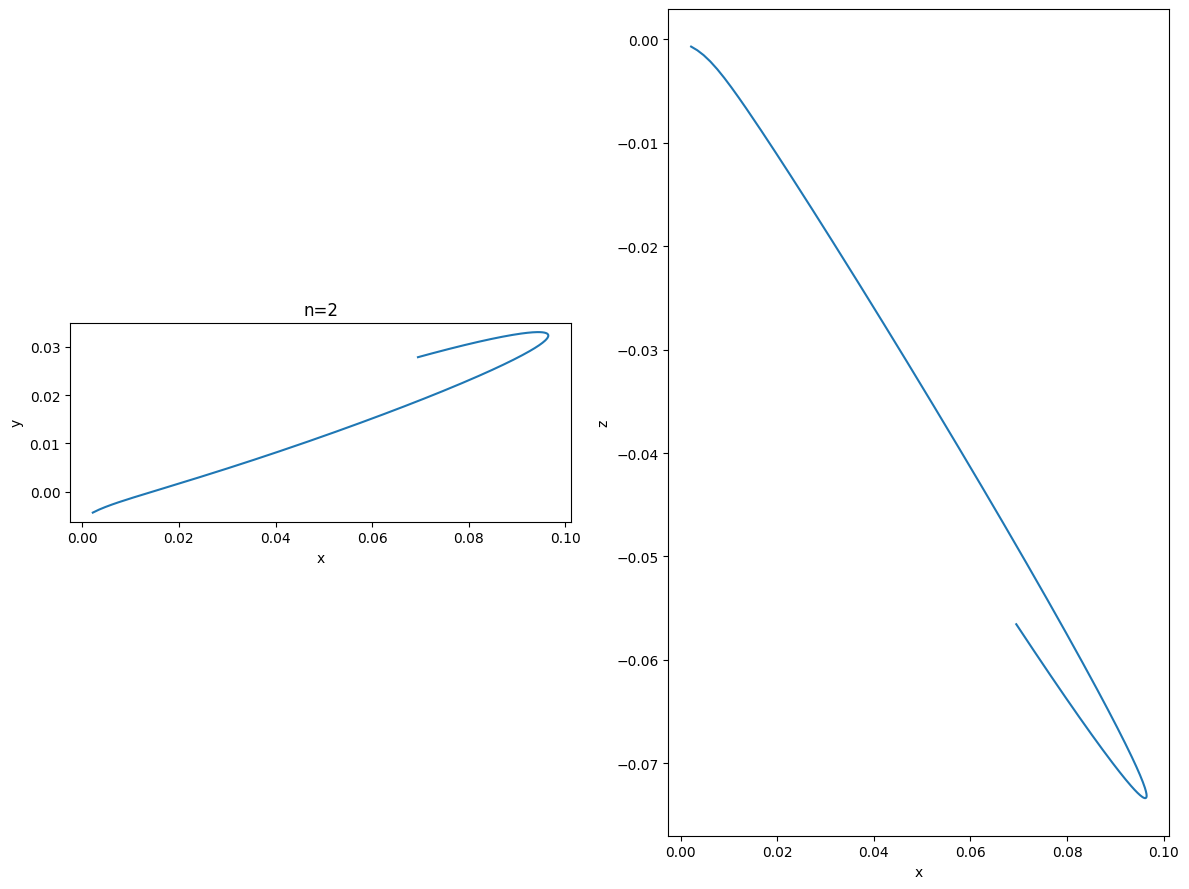

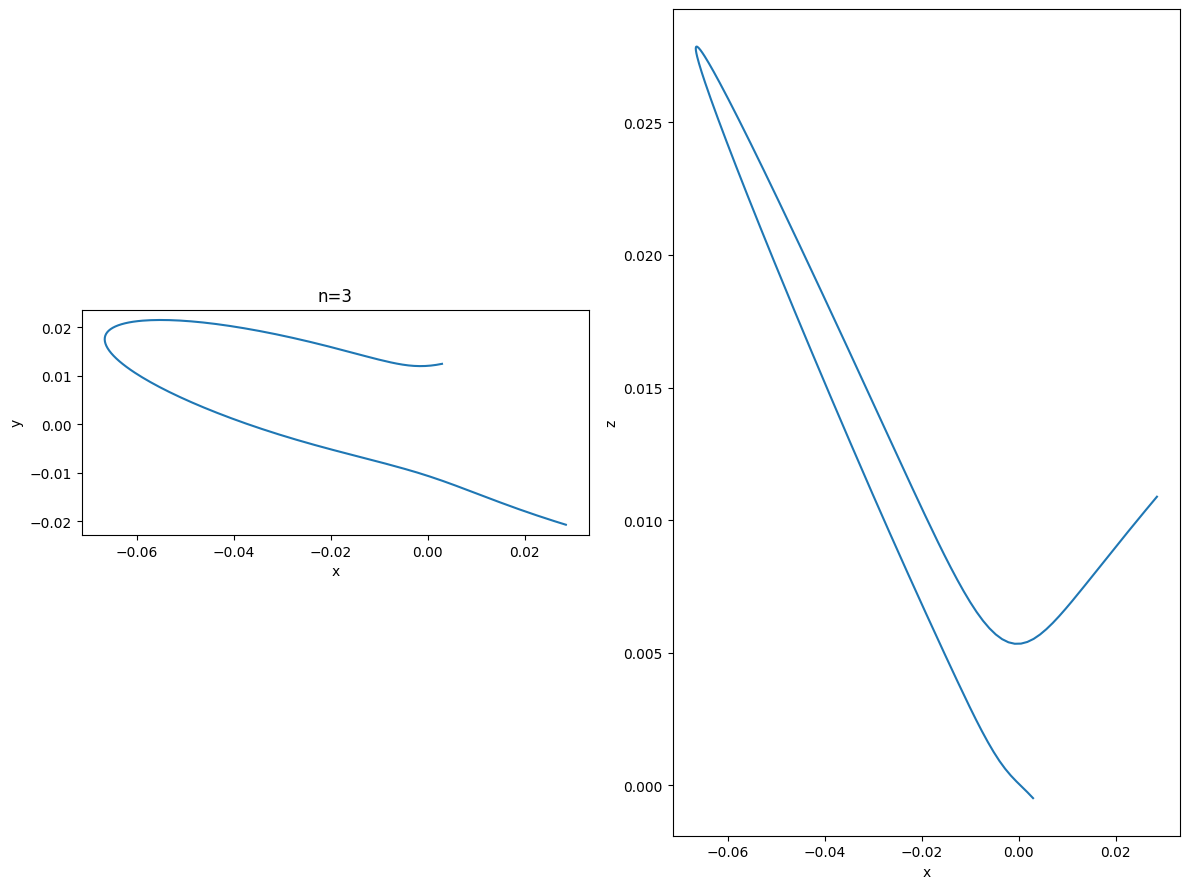

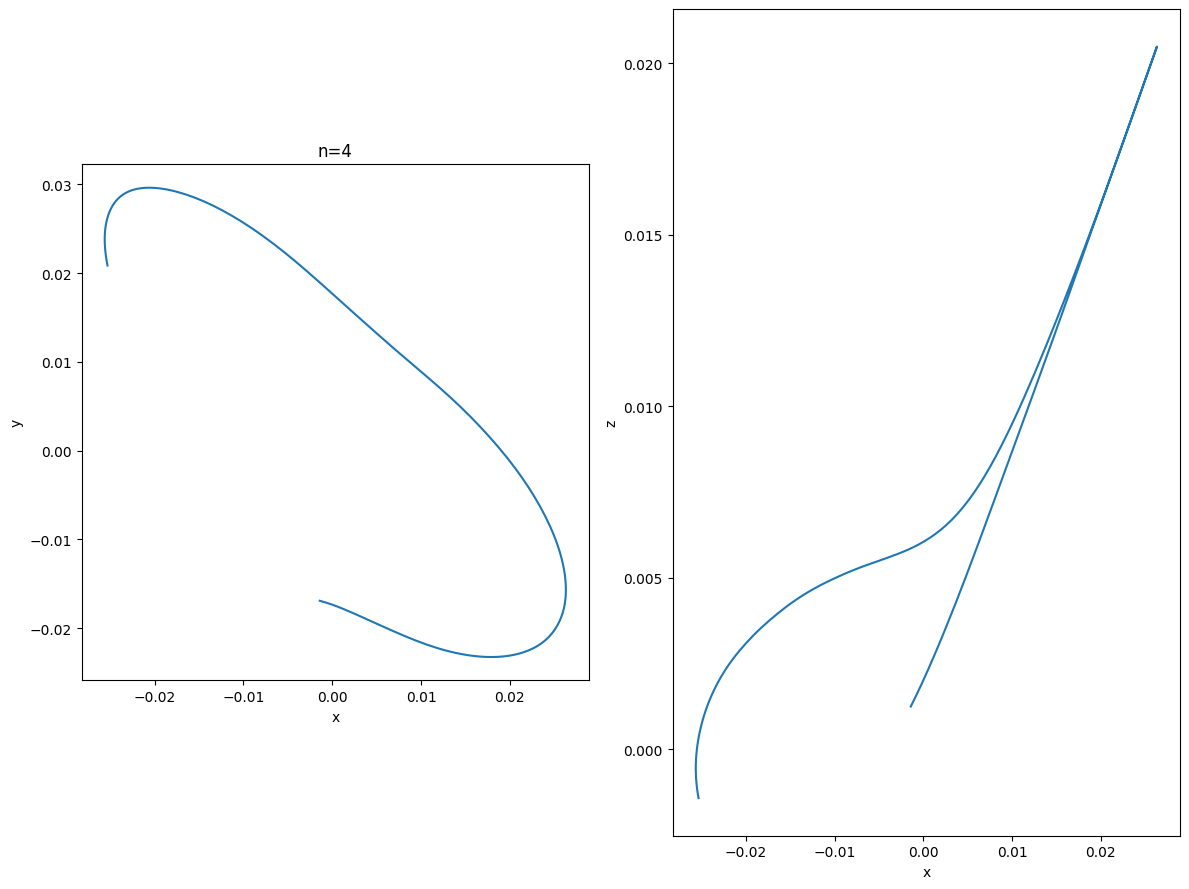

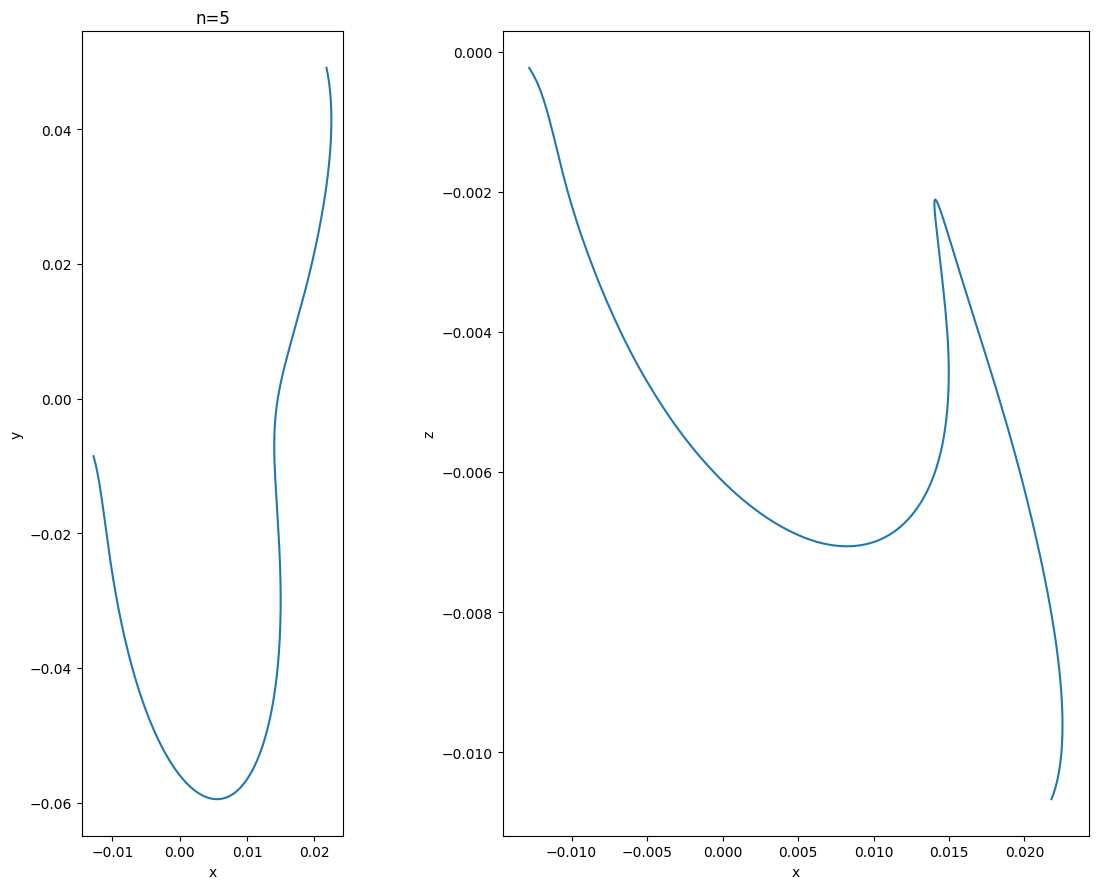

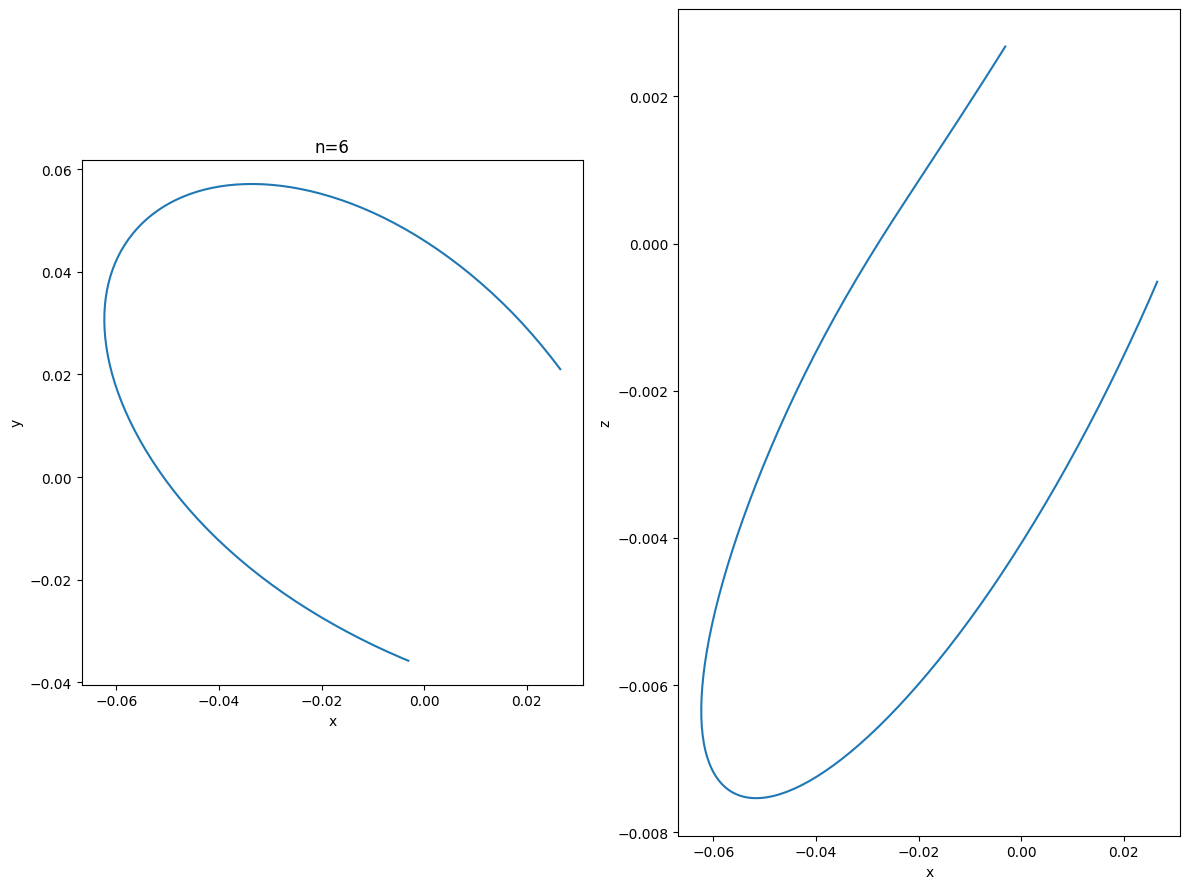

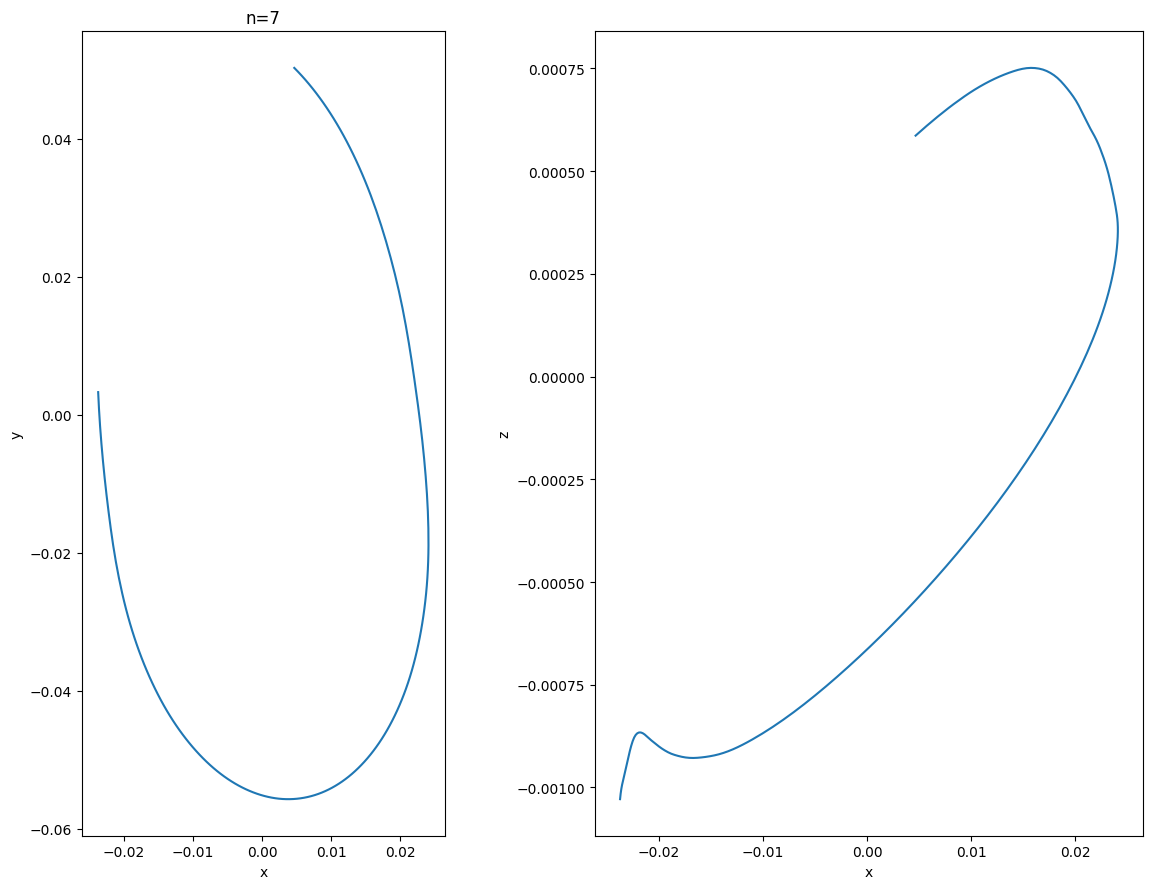

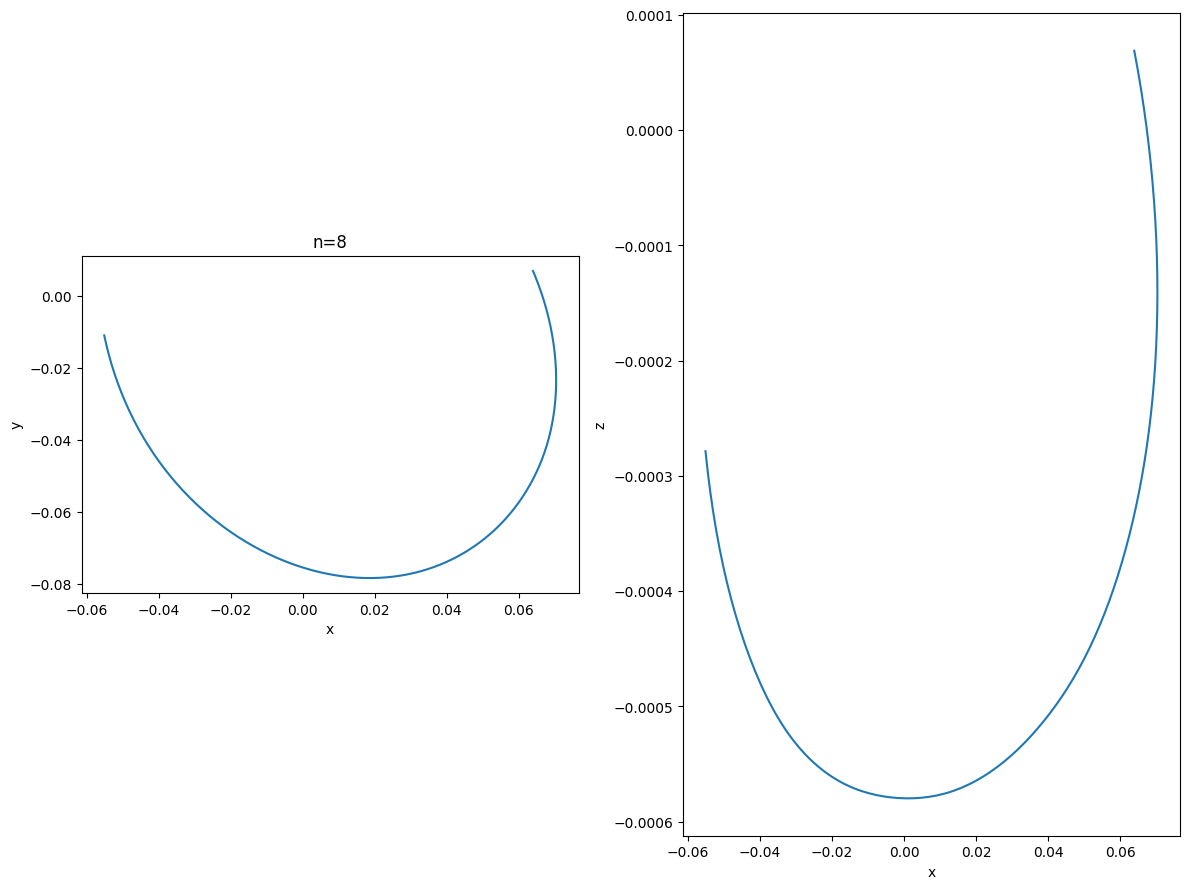

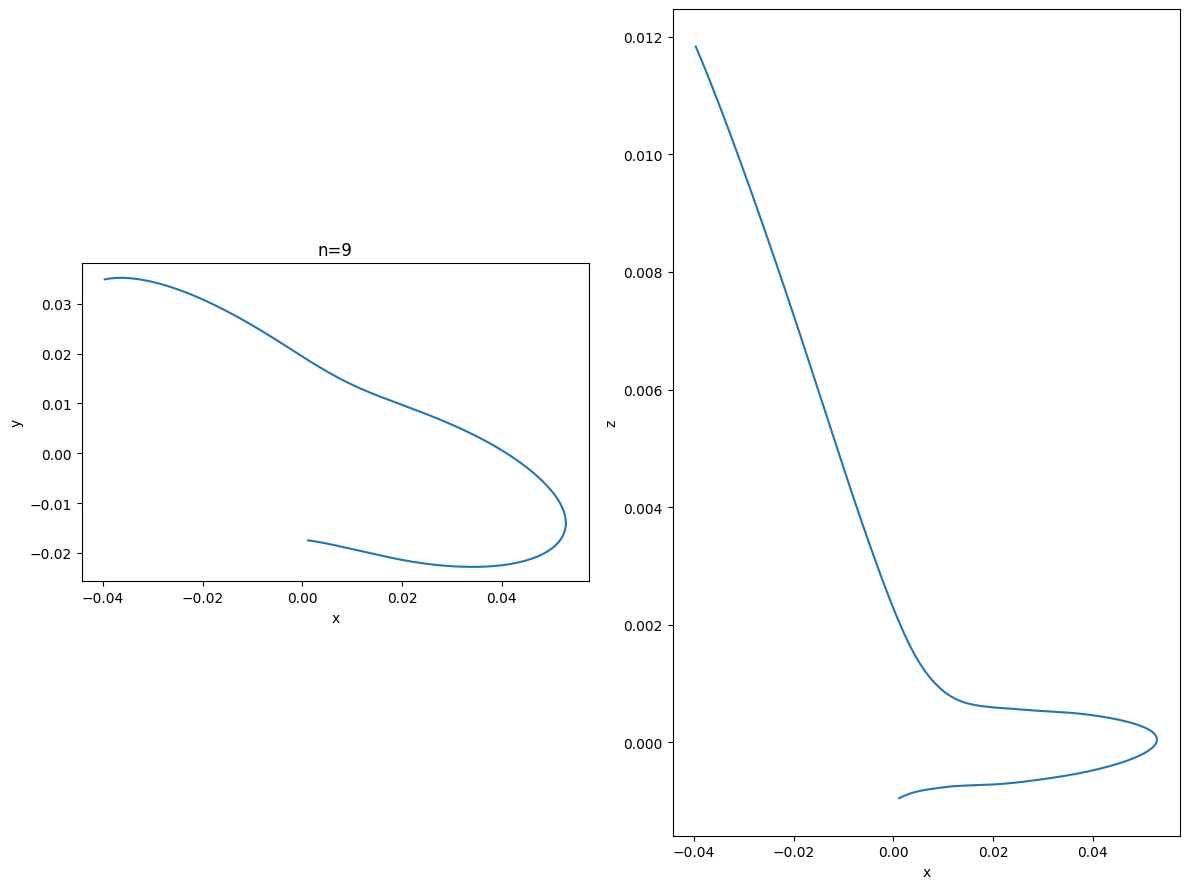

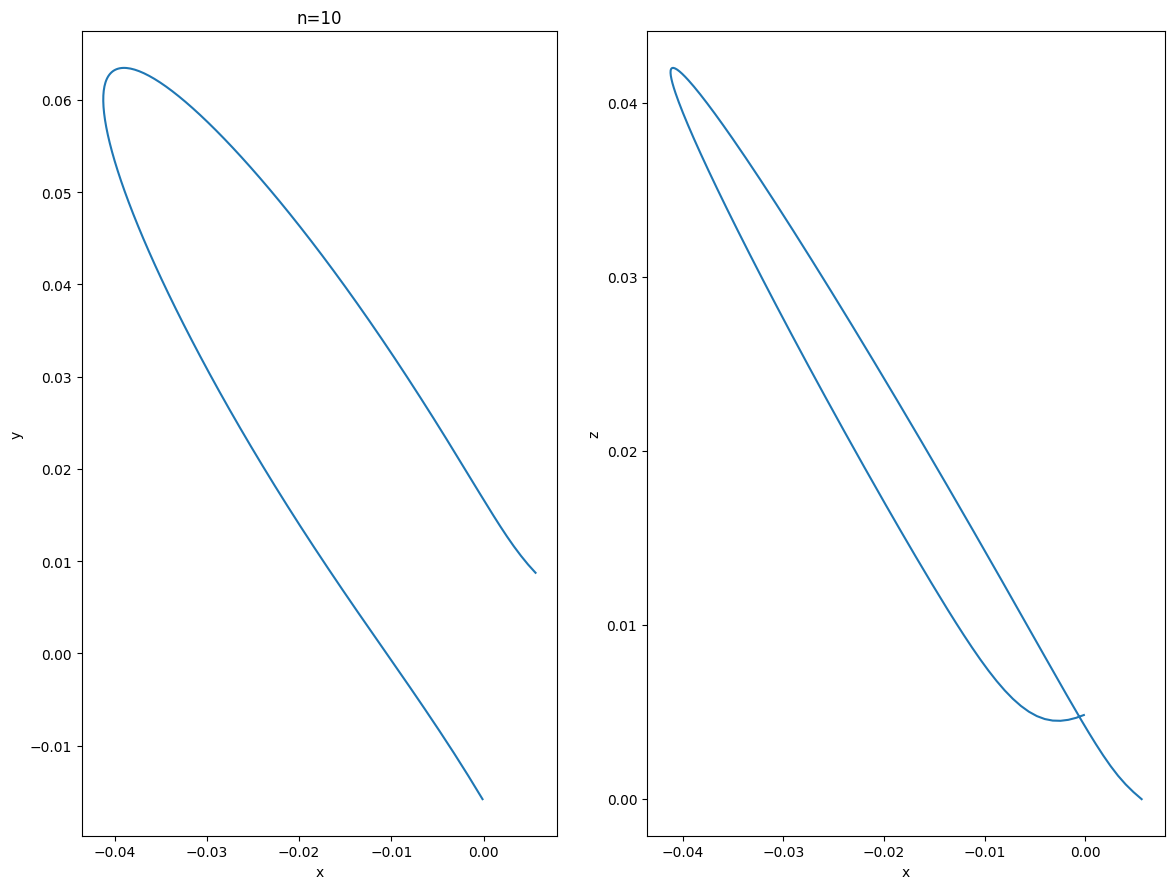

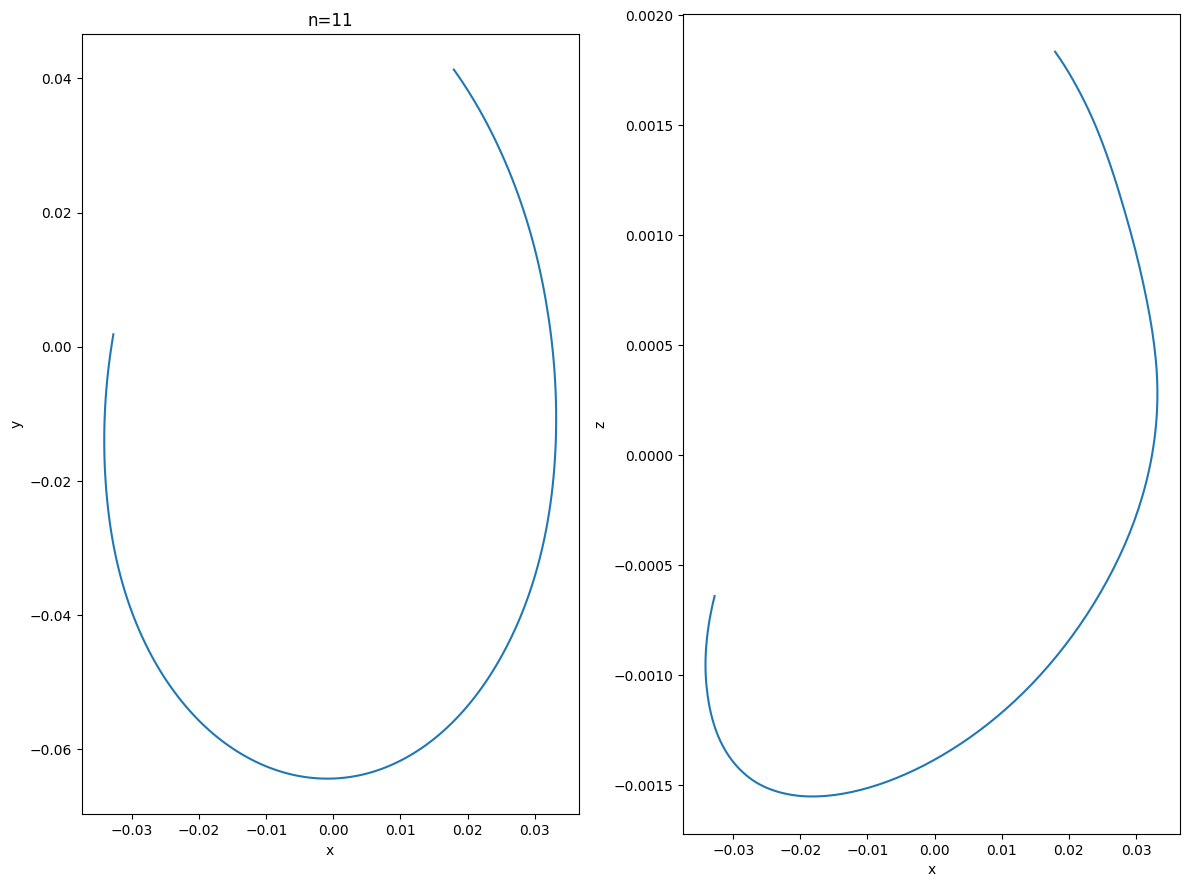

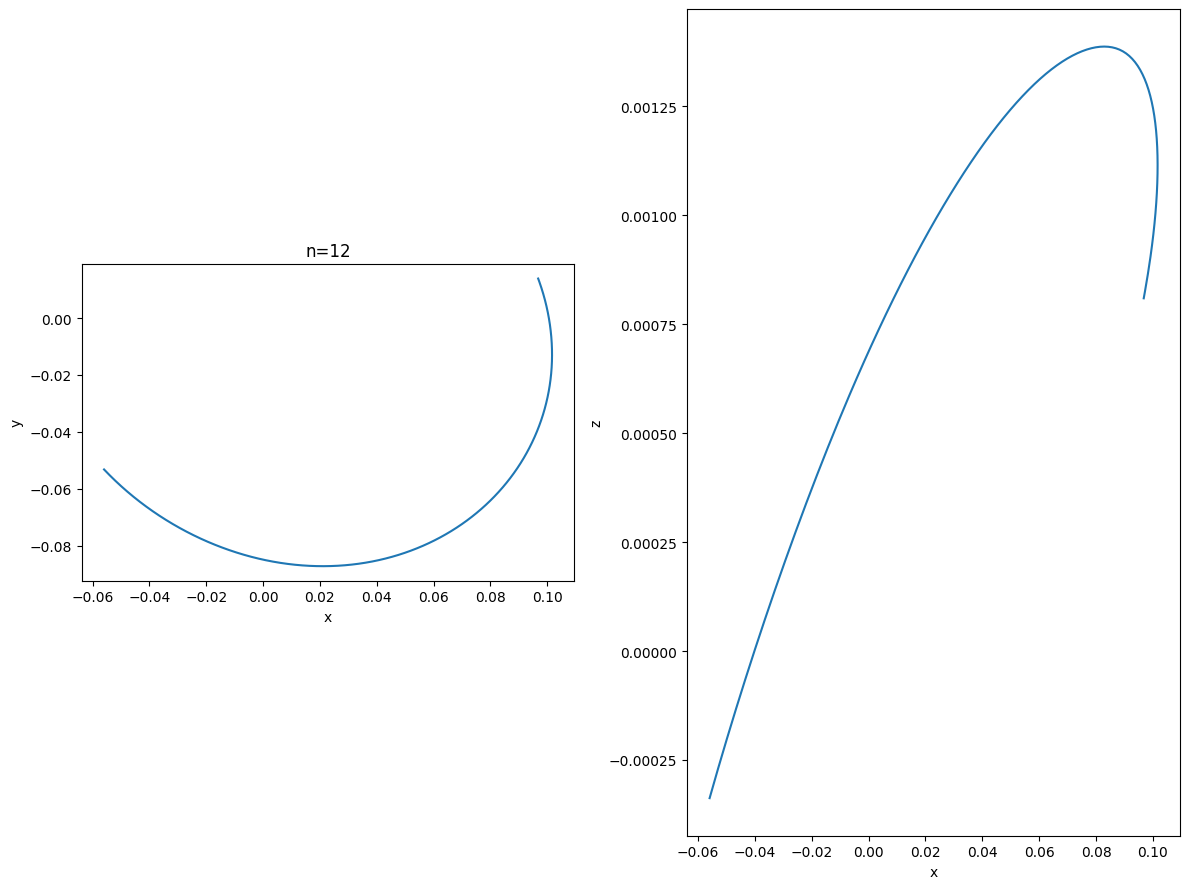

In [7]:
for n in range(orbits.shape[0]):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(orbits[n,0,:], orbits[n,1,:])
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set(aspect=1)
    ax[0].set_title('n={}'.format(n))
    ax[1].plot(orbits[n,0,:], orbits[n,2,:])
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('z')
    plt.tight_layout()
    plt.show()

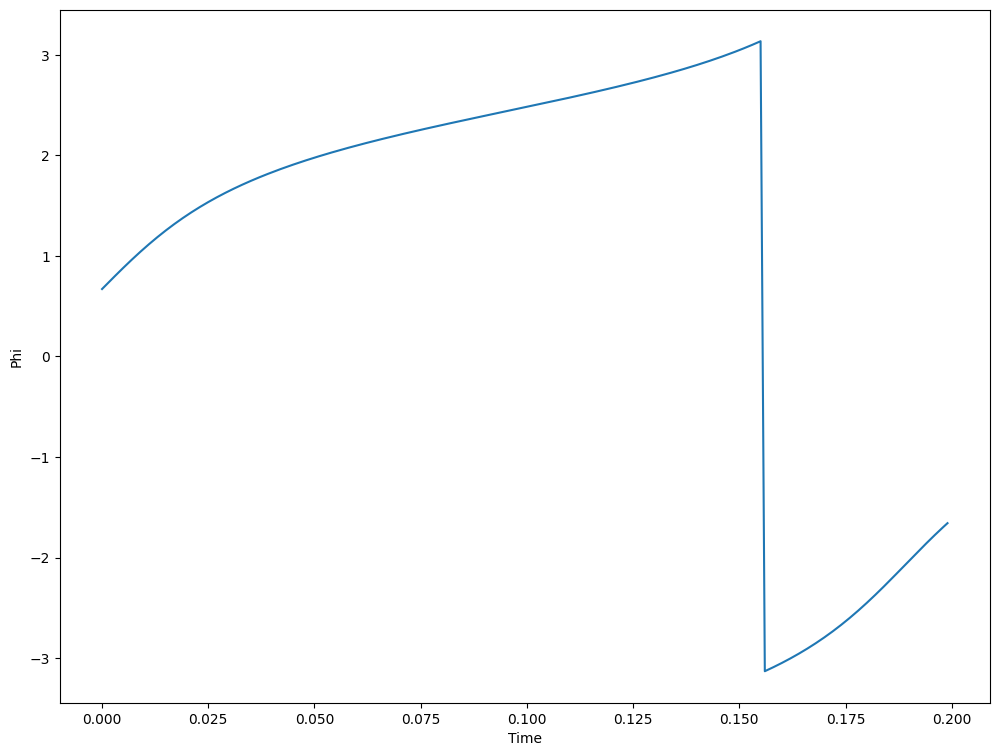

In [8]:
plt.plot(times, np.arctan2(orbits[6, 1, :], orbits[6, 0, :]))
plt.xlabel('Time')
plt.ylabel('Phi')
plt.show()

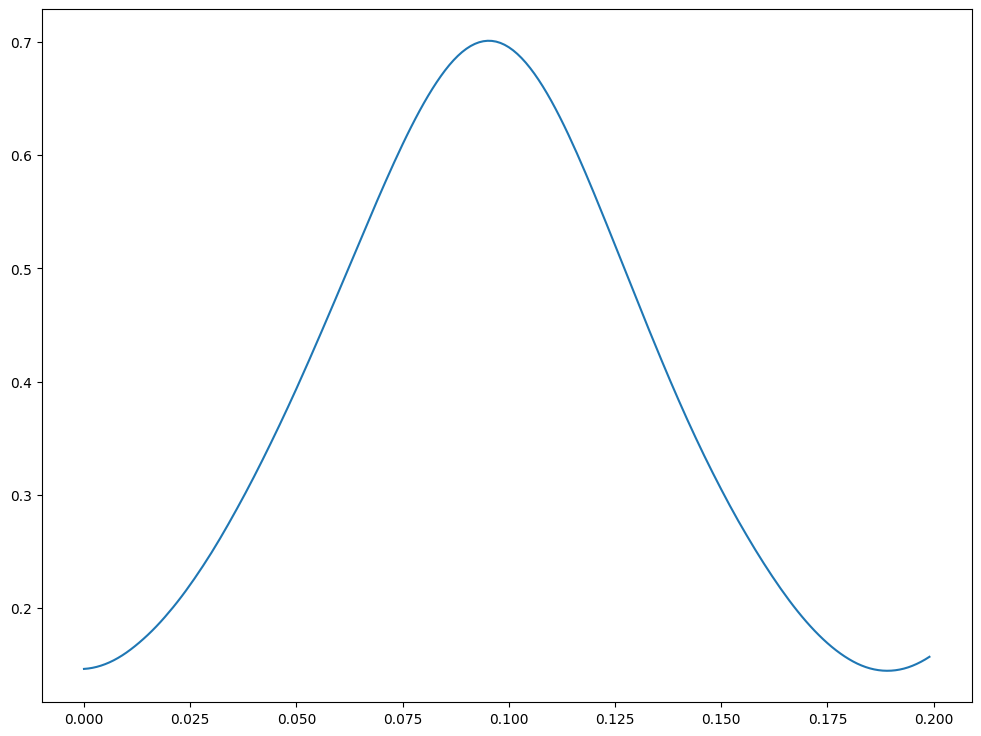

In [9]:
P = 2.0*np.pi*np.sqrt(orbits[6, 0, :]**2 + orbits[6, 1, :]**2)/np.sqrt(orbits[6, 3, :]**2 + orbits[6, 4, :]**2)
plt.plot(times, P)
plt.show()